## preprocessing

In [ ]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 957.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=7c7f95dd3b83d0d864f0fccd17be89e3f360b1b9003a3aad58c0e6ead69df7e5
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import missingno as msno
import keras
import pandas_ta as ta

In [ ]:
cac_df = pd.read_csv('/content/Cac_weekly.csv', sep = ',', header = 0)
cac_df['Date'] = pd.to_datetime(cac_df['Date'], format = '%Y-%m-%d')

cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-14'), 'Low'] = 7354.54
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-14'), 'High'] = 7523.56
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-14'), 'Close'] = 7491.96
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-14'), 'Open'] = 7443.38

cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-21'), 'Low'] = 7197.40
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-21'), 'High'] = 7493.38
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-21'), 'Close'] = 7319.18
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-21'), 'Open'] = 7467.93

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler
scaler = StandardScaler()
scaler2 = MinMaxScaler()
#attenzione USIAMO SOLO MINMAX SCALER
#standardization of the prices
cac_df[['Close', 'Open', 'Low', 'High']] = scaler2.fit_transform(cac_df[['Close', 'Open', 'Low', 'High']])
cac_df.loc[cac_df['Volume']>0, ['Volume']] = scaler2.fit_transform(cac_df.loc[cac_df['Volume']>0, ['Volume']])

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [ ]:
#hurst coeff for close prices and for log return
def hurst(ts):
    n = len(ts)
    max_window = int(n / 2)
    window_sizes = range(10, max_window)
    R_S = np.zeros(len(window_sizes))

    for i, window_size in enumerate(window_sizes):
        window_ranges = np.arange(0, n, window_size)
        R, S = 0, 0
        for j in window_ranges:
            if j + window_size < n:
                # Calculate the range and standard deviation
                window = ts[j:j+window_size]
                R += np.max(window) - np.min(window)
                S += np.std(window)

        # Calculate the rescaled range
        R_S[i] = R / S

    # Fit a linear line to log-log plot
    fit = np.polyfit(np.log(window_sizes), np.log(R_S), 1)

    # Hurst exponent is the slope of the line
    hurst_exponent = fit[0]

    return hurst_exponent

cac_df['log return'] = np.log(cac_df['Close'].shift(-1)/cac_df['Close'])
ts = cac_df['Close']
print("Hurst Exponent for Close price:", hurst(ts))

ts1 = cac_df['log return']
print("Hurst Exponent for log return:", hurst(ts1))

cac_df['return'] = cac_df['Close'].shift(-1)/cac_df['Close']
ts2 = cac_df['return']
print("Hurst Exponent for return:", hurst(ts2))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Hurst Exponent for Close price: 0.027927116555409214
Hurst Exponent for log return: nan
Hurst Exponent for return: nan


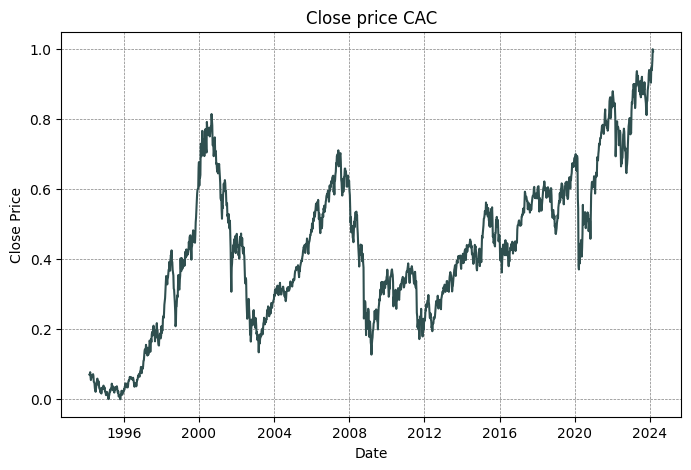

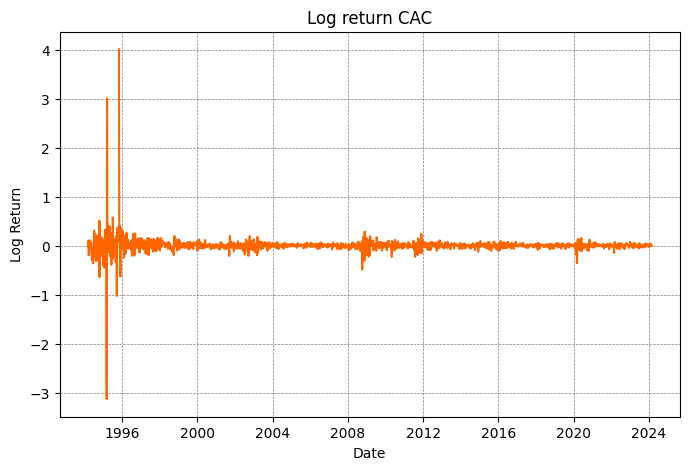

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.style.use('default')
plt.plot(cac_df['Date'], cac_df['Close'], color='#2F4F4F')
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.title('Close price CAC')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().set_facecolor('none')
plt.savefig('close cac.png', transparent=True)
plt.show()



fig, ax = plt.subplots(figsize=(8, 5))
plt.style.use('default')
plt.plot(cac_df['Date'], cac_df['log return'], color='#FF6600')
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.title('Log return CAC')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.gca().set_facecolor('none')
plt.savefig('log return cac.png', transparent=True)
plt.show()


##Prima architettura (che corrisponde alle 5a in IBM)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            640       
                                                                 
 dropout (Dropout)           (None, 10, 10)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 10)            840       
                                                                 
 dropout_1 (Dropout)         (None, 10, 10)            0         
                                                                 
 dense (Dense)               (None, 10, 1)             11        
                                                                 
Total params: 1491 (5.82 KB)
Trainable params: 1491 (5.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/30
98/98 [==============================] - 15s 41ms/step - loss: 0.1264 - val_loss: 0.0679
Epoch 2/30
98/98 [==============================] - 2s 16ms/step - loss: 0.0505 - val_loss: 0.0678
Epoch 3/30
98/98 [==============================] - 1s 14ms/step - loss: 0.0389 - val_loss: 0.0549
Epoch 4/30
98/98 [==============================] - 1s 14ms/step - loss: 0.0315 - val_loss: 0.0428
Epoch 5/30
98/98 [==============================] - 1s 10ms/step - loss: 0.0295 - val_loss: 0.0484
Epoch 6/30
98/98 [==============================] - 1s 10ms/step - loss: 0.0281 - val_loss: 0.0432
Epoch 7/30
98/98 [==============================] - 1s 10ms/step - loss: 0.0268 - val_loss: 0.0510
Epoch 8/30
98/98 [==============================] - 1s 9ms/step - loss: 0.0261 - val_loss: 0.0437
Epoch 9/30
98/98 [==============================] - 1s 10ms/step - loss: 0.0254 - val_loss: 0.0477
Epoch 10/30
98/98 [==============================] - 1s 9ms/step - loss: 0.0252 - val_loss: 0.0414
Epoch 11/3

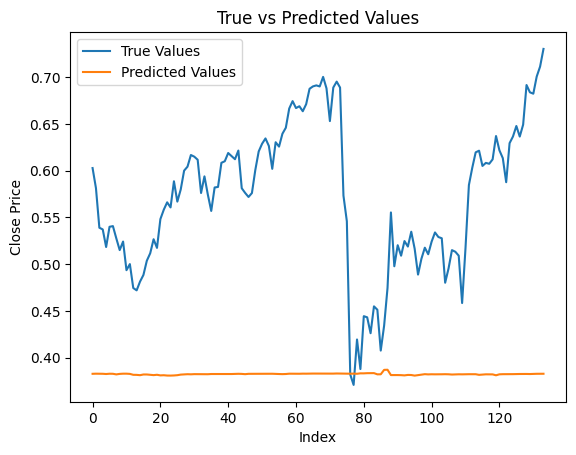

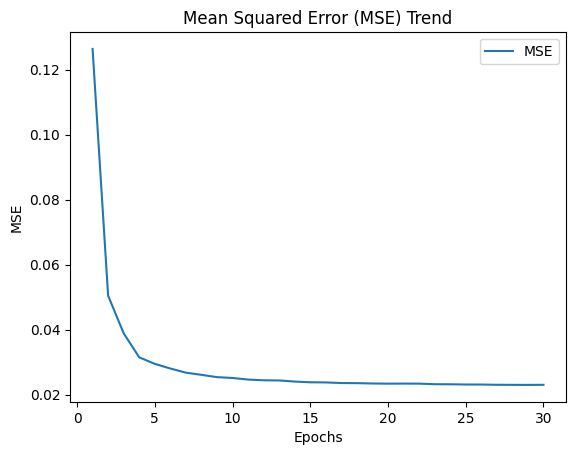

In [ ]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=10,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=10,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


cac_df['RSI']=ta.rsi(cac_df.Close, length=10)
cac_df['EMAF']=ta.ema(cac_df.Close, length=20)
cac_df['EMAM']=ta.ema(cac_df.Close, length=100)
cac_df['EMAS']=ta.ema(cac_df.Close, length=150)

cac_df.dropna(inplace=True)
splitlimit = int(len(cac_df) * 0.8)
cac_df_train_set = cac_df.loc[:cac_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=cac_df_train_set.shape[0]

for x in range(cac_df.index[0]+10, df_days): #prendo intanto una finestra di 10 settimane
  X_train.append(cac_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(cac_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(cac_df.index[0]+df_days, cac_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(cac_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(cac_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=30, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## SECONDA ARCHITETTURA: corrisponde alla 4a in ibm circa. Molti più layer, indicatori fissi, 15 epochs, finestra molto piccola: 3 settimane

In [ ]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


cac_df['RSI']=ta.rsi(cac_df.Close, length=10)
cac_df['EMAF']=ta.ema(cac_df.Close, length=20)
cac_df['EMAM']=ta.ema(cac_df.Close, length=100)
cac_df['EMAS']=ta.ema(cac_df.Close, length=150)

cac_df.dropna(inplace=True)
splitlimit = int(len(cac_df) * 0.8)
ibm_df_train_set = cac_df.loc[:cac_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(cac_df.index[0]+3, df_days):
  X_train.append(cac_df.loc[x-3:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(cac_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(cac_df.index[0]+df_days, cac_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(cac_df.loc[x-3:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(cac_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')


#training
history = model.fit(X_train, y_train,epochs=15, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 50)             11200     
                                                                 
 dropout_2 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 3, 50)             20200     
                                                                 
 dropout_3 (Dropout)         (None, 3, 50)             0         
                                                                 
 dropout_4 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 50)             20200     
                                                                 
 dropout_5 (Dropout)         (None, 3, 50)            

None

Epoch 1/15
70/72 [============================>.] - ETA: 0s - loss: 0.0771

ValueError: Expected input data to be non-empty.

In [ ]:
#nota: qui si raggiunge un loss basso, ma il validation loss rimane ancora alto